# Numerical Solutions to the Advection-Diffusion Equation   
### EASC 709: Numerical Methods
__04/21/2020__

## Mathematical Problem  

The advection-diffusion equation in one dimension ($x$) is   

\begin{equation}
    \begin{split}
        \frac{\partial u}{\partial t} + a \frac{\partial u}{ \partial x} = \kappa \frac{\partial^2 u}{\partial x^2}
    \end{split}
    \quad \quad
    \begin{split}
        &u(x,t)\text{ is a scalar field }\\
        &\kappa\text{ is a diffusivity coef.}\\
        &a \text{ is a scalar velocity}
    \end{split}
\end{equation}  

In order to solve this equation (numerically or analytically) we need initial conditions at $t_0$  

\begin{align}
  u(x,t_0) = \eta(x)
\end{align}

and boundary conditions (in the case of a finite domain)  

\begin{align}
\begin{aligned}
  u(0, t) = g_0(t) \;\;\; \text{for} \;\;\; t>0\\
  u(L, t) = g_0(t) \;\;\; \text{for} \;\;\; t>0
\end{aligned}
\end{align}  
on the domain $0<x<L$.

## Numerical Approaches  

Lets rewrite advection-diffusion equation  
\begin{align}
    \frac{\partial u}{\partial t} + a \frac{\partial u}{ \partial x} = \kappa \frac{\partial^2 u}{\partial x^2}
\end{align}  
as 
\begin{align}
  \underbrace{u_t}_{\frac{\partial u}{\partial t}} = \underbrace{\mathcal{A}(u)}_{ a \frac{\partial u}{ \partial x} } + \underbrace{\mathcal{B}(u)}_{\kappa \frac{\partial^2 u}{\partial x^2}} \;\; . 
\end{align}

In the case of Adv.-Diff. Eqn. 

### Fractional Step Methods : __Godunov Splitting__    

For the equation

\begin{align}
  u_t = \mathcal{A}(u) + \mathcal{B}(u)
\end{align}

the simplest (first-order) numerical solution takes the form:

\begin{align}
\begin{aligned}
U^* &= \mathcal{N}_{\mathcal{A}}(U^n,k), \\
U^{n+1} &= \mathcal{N}_{\mathcal{B}}(U^*,k)
\end{aligned}
\end{align}

where:  
  - $\mathcal{N}_{\mathcal{A}}(U^n,k)$ solves $u_t = \mathcal{A}(u)$ over a time step $k$ with input data, $U^n$ 
  - $\mathcal{N}_{\mathcal{B}}(U^*,k)$ similarly solves  $u_t = \mathcal{B}(u)$ over a time step $k$ but with input data $U^*$  
  
such that: 
  - $\mathcal{N}_{\mathcal{A}}(U^n,k)$ is an optimal method to solve $u_t = \mathcal{A}(u)$
  - $\mathcal{N}_{\mathcal{B}}(U^*,k)$ is an optimal method to solve $u_t = \mathcal{B}(u)$ .

### Fractional Step Methods:  __Strang Splitting__    
A second-order accurate method for solving the equation:  

\begin{align}
  u_t = \mathcal{A}(u) + \mathcal{B}(u)
\end{align}  
known a Strang Splitting is:  
\begin{align}
\begin{aligned}
U^* &= \mathcal{N}_{\mathcal{A}}(U^n,k/2), \\
U^{**} &= \mathcal{N}_{\mathcal{B}}(U^*,k), \\
U^{n+1} &= \mathcal{N}_{\mathcal{A}}(U^{**},k/2) \;\; .
\end{aligned}
\end{align}

## Fractional Step Methods:  

__Pros__:  
  - Avoid a non-linear system of equations that could arise if you discretized the equation with a fully implicit method. 
  - Easy to implement! (Kinda...)  
  
__Cons__:
  - If the sub-methods used ($\mathcal{N}_{\mathcal{A}} \; \& \; \mathcal{N}_{\mathcal{B}}$) are at least second order accurate, the highest order accuracy you can achieve is second order accuracy (for Strang Splitting). 
  - Even if sub-methods ($\mathcal{N}_{\mathcal{A}} \; \& \; \mathcal{N}_{\mathcal{B}}$) are stable to timestep $k$, it is not guaranteed that the splitting methods will be stable. 
  - Does not account of a coupling between $\mathcal{A}(u) \; \& \; \mathcal{B}(u)$

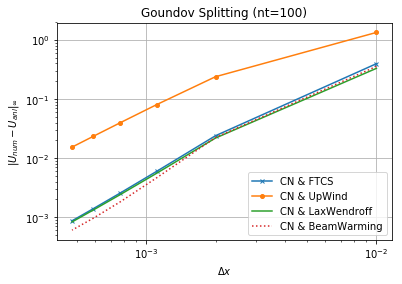

In [6]:
import numpy as np
import scipy.linalg as LA
import matplotlib.pyplot as plt
from advdiff.model import Diffusion, AdvDiff
#from advdiff.heuristic import AdvDiff

params = {'L':4.*np.pi,'nx':100,'nt':100}
coeffs = {'κ':0.3, 'σ':0.75, 'a':3.}

def initcond(test, M = 1,P = 1,x_0 = np.pi,t=0.1):
    return (M / (P *(4*np.pi*test.κ*t)**0.5)) * np.exp(-(((test.x-(x_0 + test.a*t))**2)/(4*test.κ*t)))

nxs   = np.arange(100,2500,400)
err_G = np.zeros((4,nxs.shape[0]))

for i, nx in enumerate(nxs):
    params['nx'] = nx
    test = AdvDiff(params,coeffs)
    test.U[0,:] = initcond(test)
    FTCS_G    = test.Goundov('FTCS','w')
    UpWind_G  = test.Goundov('UpWind','w')
    LaxWendroff_G = test.Goundov('LaxWendroff','w')
    BeamWarming_G  = test.Goundov('BeamWarming','w')

    analytical = np.zeros((params['nt'],params['nx']))
    for t in range(0,params['nt']):
        analytical[t,:] = initcond(test,t=(t*test.dt+0.1))
        
    err_G[0,i] = LA.norm(analytical - FTCS_G, np.inf)
    err_G[1,i] = LA.norm(analytical - UpWind_G, np.inf)
    err_G[2,i] = LA.norm(analytical - LaxWendroff_G, np.inf)
    err_G[3,i] = LA.norm(analytical - BeamWarming_G, np.inf)

# for t in range(params['nt']):
#     plt.plot(test.x, second[t,:])
# plt.show()

fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.grid()

ax.set_ylabel(r'$|U_{num} - U_{anl}|_\infty$')
ax.set_xlabel('$\Delta x$')
ax.set_title(r'Goundov Splitting (nt=100)')

ax.loglog(1/nxs,err_G[0],'x-',label='CN & FTCS',markersize=4,basey=10)
ax.loglog(1/nxs,err_G[1],'o-',label='CN & UpWind',markersize=4,basey=10)
ax.loglog(1/nxs,err_G[2],'-' ,label='CN & LaxWendroff',markersize=4,basey=10)
ax.loglog(1/nxs,err_G[3],':' ,label='CN & BeamWarming',markersize=4,basey=10)
plt.legend()

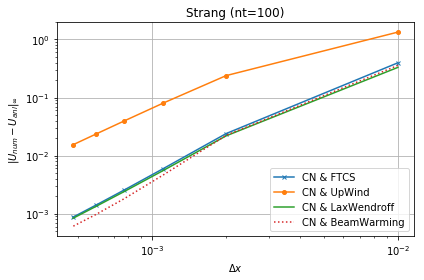

In [7]:
#!/usr/bin/env python3

params = {'L':4.*np.pi,'nx':100,'nt':100}
coeffs = {'κ':0.3, 'σ':0.75, 'a':3.}

def initcond(test, M = 1,P = 1,x_0 = np.pi,t=0.1):
    return (M / (P *(4*np.pi*test.κ*t)**0.5)) * np.exp(-(((test.x-(x_0 + test.a*t))**2)/(4*test.κ*t)))

nxs   = np.arange(100,2500,400)
err_S = np.zeros((4,nxs.shape[0]))

for i, nx in enumerate(nxs):
    params['nx'] = nx
    test = AdvDiff(params,coeffs)
    test.U[0,:] = initcond(test)
    FTCS_S  = test.Strang('FTCS','w')
    UpWind_S  = test.Strang('UpWind','w')
    LaxWendroff_S = test.Strang('LaxWendroff','w')
    BeamWarming_S = test.Strang('BeamWarming','w')

    analytical = np.zeros((params['nt'],params['nx']))
    for t in range(0,params['nt']):
        analytical[t,:] = initcond(test,t=(t*test.dt+0.1))

    err_S[0,i] = LA.norm(analytical - FTCS_S, np.inf)
    err_S[1,i] = LA.norm(analytical - UpWind_S, np.inf)
    err_S[2,i] = LA.norm(analytical - LaxWendroff_S, np.inf)
    err_S[3,i] = LA.norm(analytical - BeamWarming_S, np.inf)

# for t in range(params['nt']):
#     plt.plot(test.x, LaxWendroff[t,:])
# plt.show()

fig, ax = plt.subplots(1,1,figsize=(6,4))
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.loglog(1/nxs,err_S[0],'x-',label='CN & FTCS',markersize=4,basey=10)
ax.loglog(1/nxs,err_S[1],'o-',label='CN & UpWind',markersize=4,basey=10)
ax.loglog(1/nxs,err_S[2],'-', label='CN & LaxWendroff',markersize=4,basey=10)
ax.loglog(1/nxs,err_S[3],':',label='CN & BeamWarming',markersize=4,basey=10)

ax.grid()
#
#ax.axhline(1e-16,nxs[0],nxs[-1])
ax.set_ylabel(r'$|U_{num} - U_{anl}|_\infty$')
ax.set_xlabel('$\Delta x$')
ax.set_title(r'Strang (nt=100)')
plt.legend()

# fig, ax = plt.subplots(1,1,figsize=(6,4))
# ax.plot(test.x,UpWind_S[-1,:],'x')
# ax.plot(test.x,LaxWendroff_S[-1,:],'x')
# ax.plot(test.x,BeamWarming_S[-1,:],'x')
# ax.plot(test.x,analytical_S[-1,:])
plt.tight_layout()
plt.show()


In [14]:
err_S[0]

array([0.39615687, 0.0239546 , 0.00599329, 0.00255684, 0.00139361,
       0.00087146])

In [13]:
err_G[0]

array([0.3961475 , 0.02395448, 0.00599328, 0.00255684, 0.00139361,
       0.00087146])